In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib inline

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from arch.unitroot import VarianceRatio
from itertools import groupby
from scipy.stats import norm
from sklearn.metrics import r2_score
from statsmodels.robust.scale import mad

from sgmbasketball.models.factor_model.play_by_play_data import PlayByPlayCleanData
from stratagemdataprocessing.data_api import find_basketball_events

from sgmresearchbase.coint.space import normalise
from sgmresearchbase.coint.common import hurst_naive
from sgmresearchbase.coint.services import CointegrationService, _zs
from sgmresearchbase.coint.projection import interpolate

from IPython.display import clear_output

In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

In [5]:
START_DT = datetime.datetime(2016, 10, 1)
END_DT = datetime.datetime(2017, 6, 1)

ALL_EVENTS = find_basketball_events(START_DT, END_DT, True)
NBA_EVENTS = filter(lambda e: e['stage_name'] == 'NBA', ALL_EVENTS)

PBP = PlayByPlayCleanData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', 'pbp', fixture_filter=None).get_data_ready()
clear_output()

In [221]:
data = PBP.loc[2352895]
X = data[['points_h', 'points_a']].values

In [222]:
scoring_rates = np.array([np.gradient(X[:, 0]), np.gradient(X[:, 1])]).T
smoothed = pd.ewma(scoring_rates, halflife=100, min_periods=100)[100:]

/home/tspooner/.venv/st/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


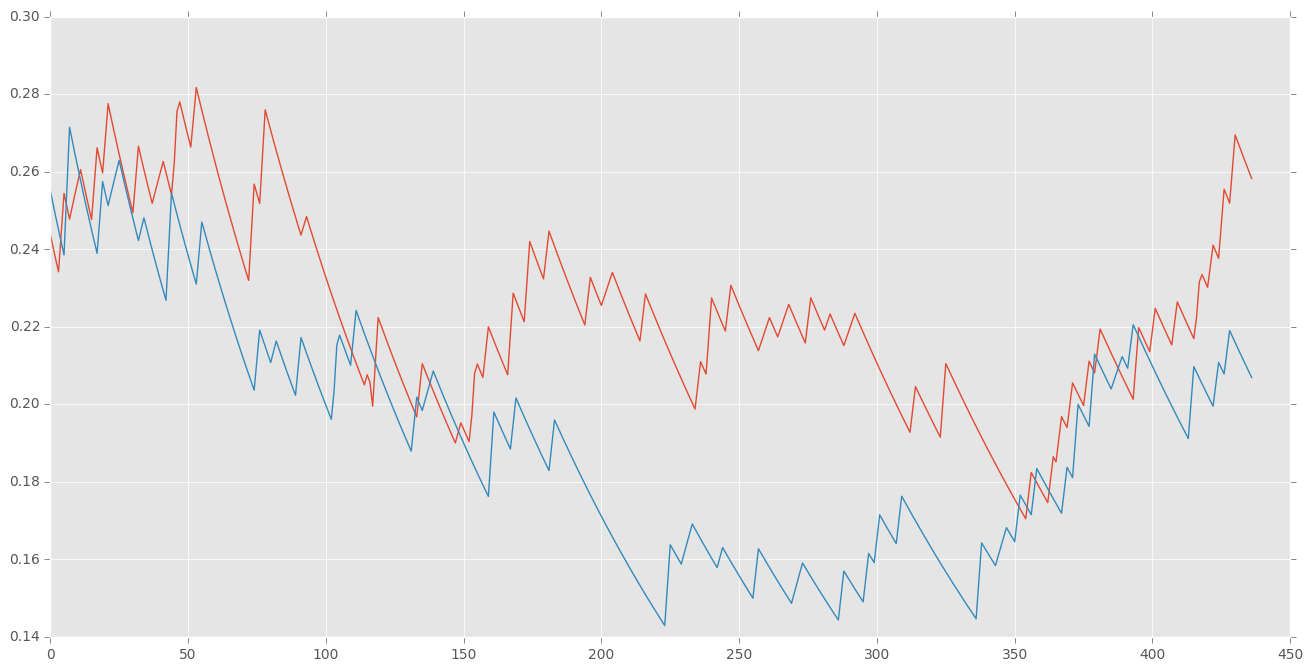

In [223]:
plt.plot(smoothed)

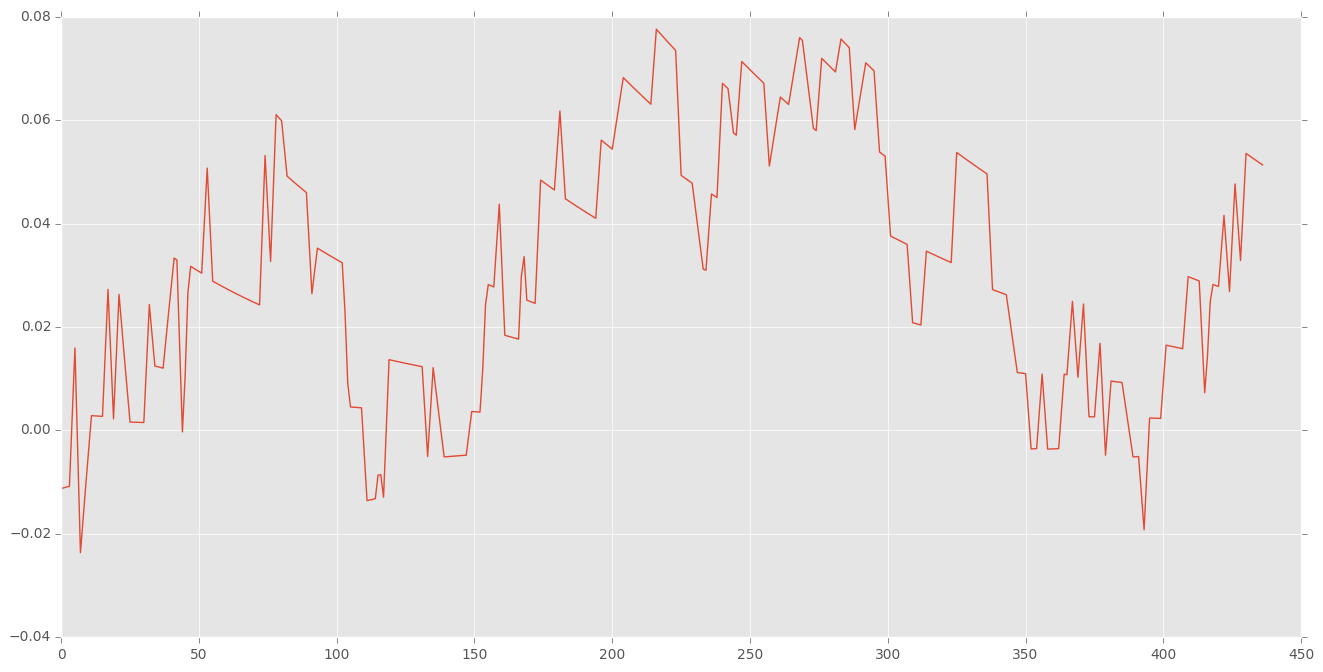

In [229]:
plt.plot(smoothed[:, 0] - smoothed[:, 1])

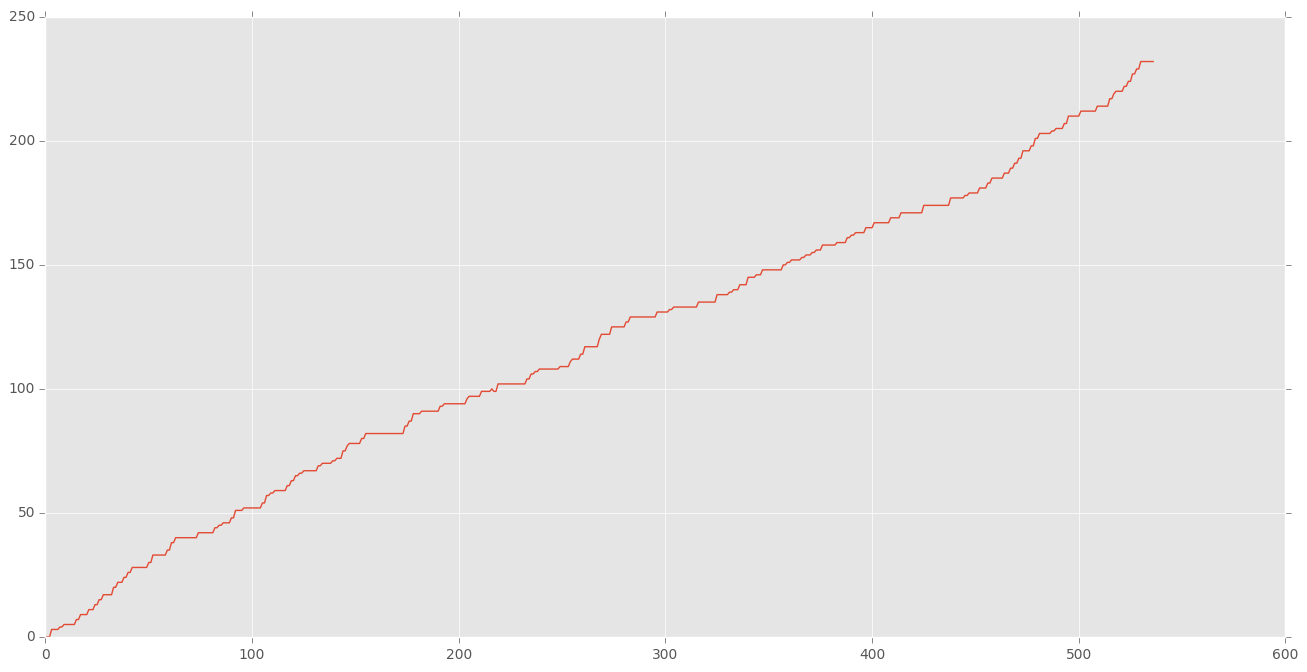

In [231]:
plt.plot(X[:, 0] + X[:, 1])

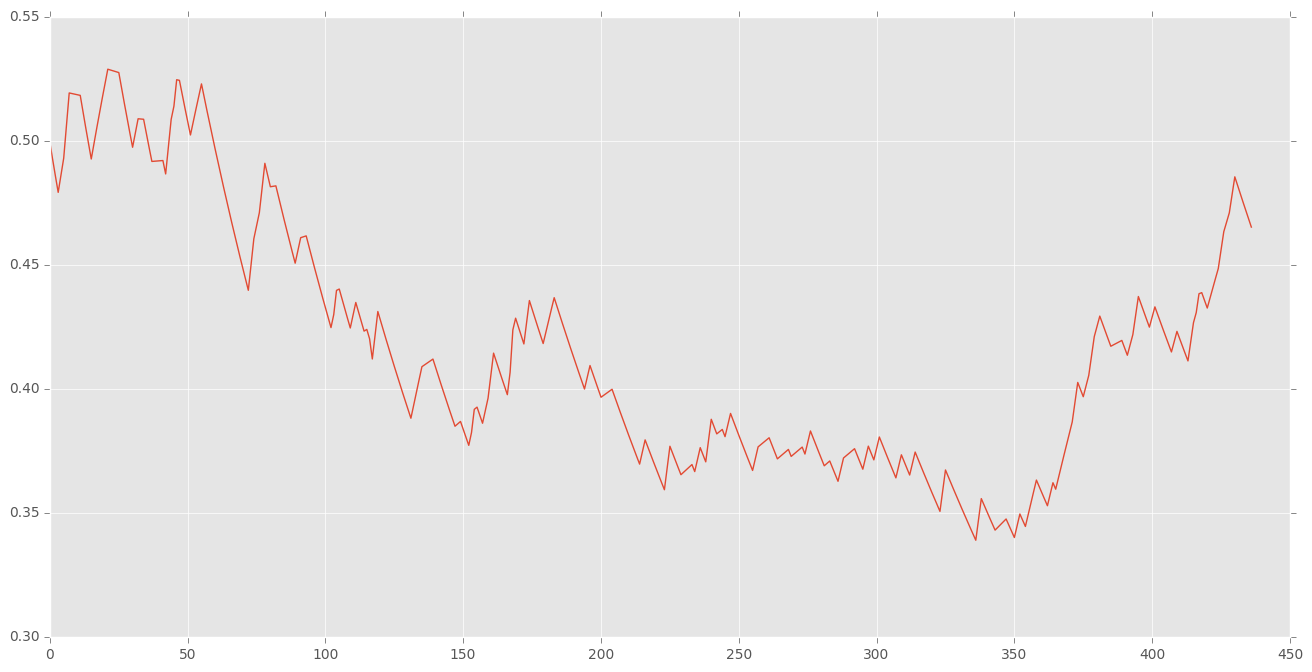

In [230]:
plt.plot(smoothed[:, 0] + smoothed[:, 1])

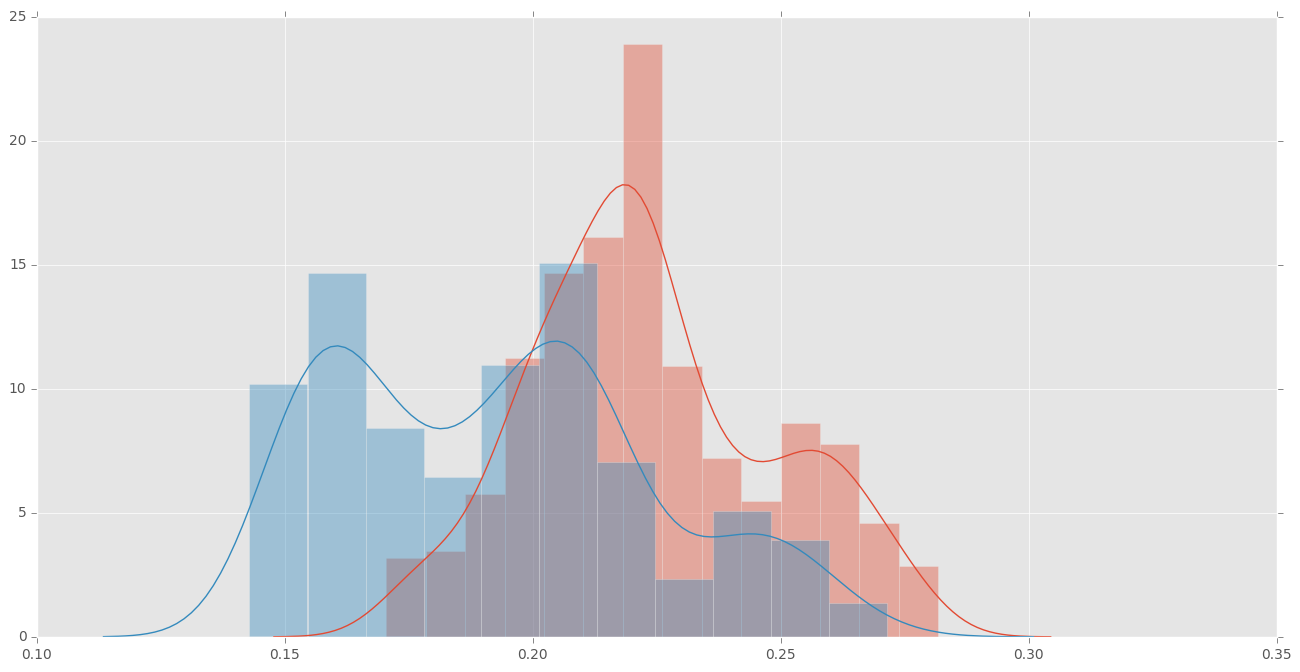

In [224]:
sns.distplot(smoothed[:, 0])
sns.distplot(smoothed[:, 1])

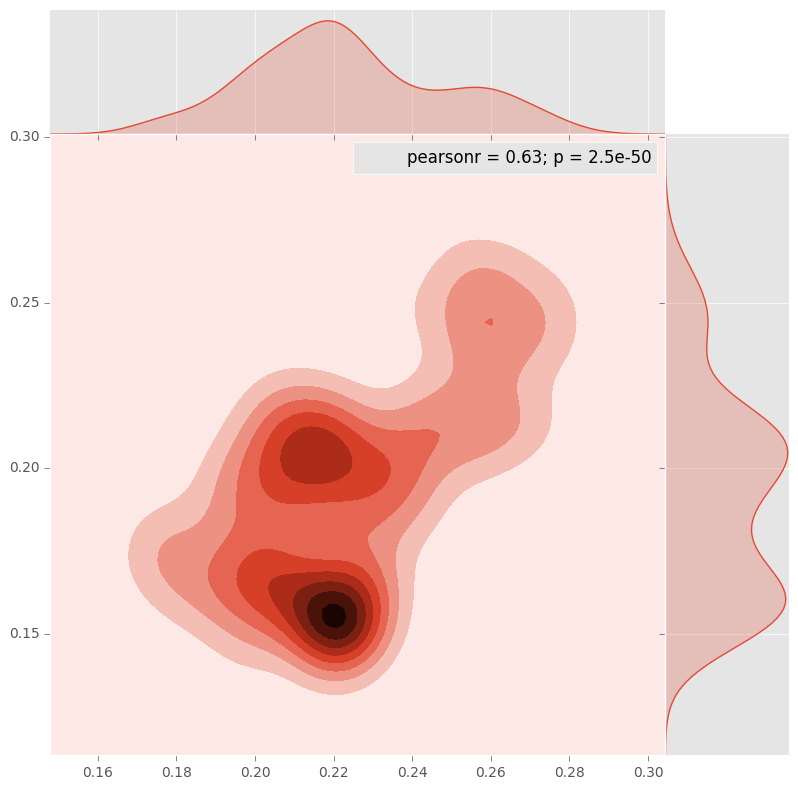

In [225]:
sns.jointplot(smoothed[:, 0], smoothed[:, 1], kind='kde', space=0, size=8)

In [226]:
def get_basis(vals, model=1):
    if vals.shape[0] < 10:
        return np.zeros((2,))

    both_bases = CointegrationService.get_cointegrating_bases(vals, model=model)
    if both_bases is None:
        return np.zeros((2,))

    if both_bases[0, 0]*both_bases[1, 0] < 0:
        basis = both_bases[:, 0]
    elif both_bases[0, 1]*both_bases[1, 1] < 0:
        basis = both_bases[:, 1]
    else:
        basis = both_bases[:, 0]*0.0    

    if basis[0] < 0:
        basis = -basis

    return basis

In [227]:
def get_spread(vals, basis):
    spd = CointegrationService.get_spread_series(vals, basis)
    mad_ = mad(spd, center=np.median, c=1)
    mean_ad = mad(spd, center=np.mean, c=1)

    if abs(mad_) < 1e-7:
        return (spd - np.median(spd)) / 1.253314 / mean_ad
    else:
        return (spd - np.median(spd)) / 1.486 / mad_

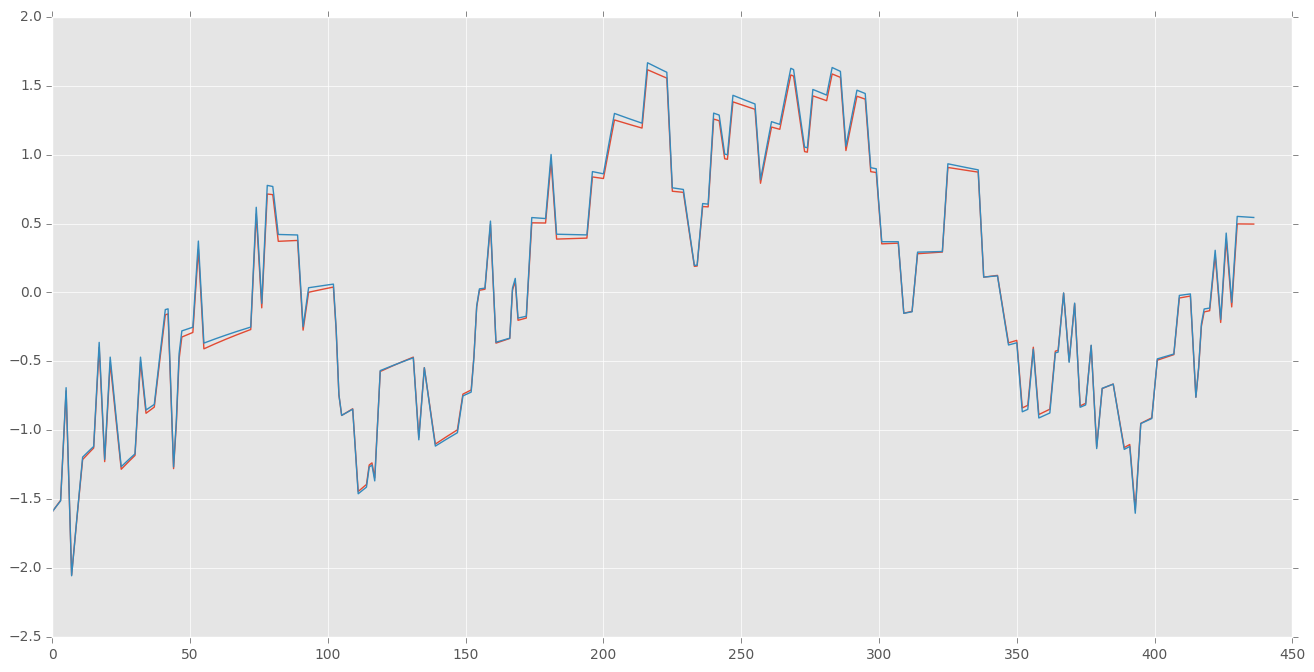

In [228]:
plt.plot(get_spread(smoothed, get_basis(X, model=1)))
plt.plot(get_spread(smoothed, get_basis(scoring_rates, model=0)))